# GPHY 491-591: Lab 4

Written by Cascade Tuholske, Jan. 2024


## Goals
The goal of Lab 4 is to expand our knowledge of integrating human and environmental geospatial datasets to understand exposure to natural hazards. This Lab will have less direction than previous labs, but will also function more like a tutorial.   

We will measure how many people were exposed to the devastating [2015 Nepal Earthquake](https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake) across [five gridded population datasets](https://www.popgrid.org). This analysis comes from a paper ([link here](https://www.mdpi.com/1171374?trk=public_post_reshare-text)) I published a few years ago. We look at how measures of exposure to three different natural disasters to illustrate how population exposure estimates can vary depending on the human dataset you use. This has big policy implications from resource allocation during response, to figuring out how much money is needed to rebuild.  

Good luck!
<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

In [1]:
# dependencies 
import os 
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio 
import rioxarray as rio
from glob import glob
from rasterio.enums import Resampling
import xarray as xr
from scipy.stats import variation 
import rasterio.mask
from rasterstats import zonal_stats, gen_zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
Patch = patches.Patch

/tmp/ipykernel_292176/2232547967.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Step 1
Resample the 250m urban/rural raster and resample it to 1-km.

In [2]:
def resample(fn_in, fn_out, scale_factor, method):
    
    """ Resamples a raster and save it out
    Args:
        fn_in = file path and name of tif input as str
        fn_out = file path and name of tif output as str 
        scale_factor = factor to up or down scale a pixel as float
        method = method to resample (rasterio object), see rasterio documentation
    """
    
    with rasterio.open(fn_in) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * scale_factor),
                int(dataset.width * scale_factor)
            ),
            resampling=method
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
    
    # meta data to write out
    out_meta = dataset.meta

    # Update meta data
    out_meta.update({"driver": "GTiff",
             "height": data.shape[1],
             "width": data.shape[2],
             "transform": transform})

    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(data)

In [3]:
# File paths
data_in = os.path.join('/home/group/earthsciences/gphy591/github/GPHY-491-591/materials/Day7/data/')
data_out = os.path.join('./')

In [4]:
# File names
modis_in = os.path.join(data_in+'MGUP_annual_2001_2018/MGUP_2015.tif')
modis_out = os.path.join(data_out+'MGUP_2015-1km.tif')

In [ ]:
# Resample and save the MODIS landcover raster
resample(modis_in, modis_out, 0.5, Resampling.mode)

# Step 2

The second step is to clip population rasters to Nepal's boundaries. This will reduce our memory use a lot and speed things up - the population rasters are quite large. 

In [6]:
# Functions
def raster_clip(rst_fn, polys, fn_out):
    
    """ function clips a raster and saves it out
    args:
        rst_fn = raster you want to clip
        polys = polys you want to clip to
        fn_out = path/to/file/out ... name of file you want to save 
    """
    
    # clip raster
    with rasterio.open(rst_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, polys, crop=True)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [7]:
# File paths
data_in = os.path.join('/home/group/earthsciences/gphy591/github/GPHY-491-591/materials/Day7/data/')
data_out = os.path.join('./')

In [8]:
# Set up the file paths for each raster 
wp_path = os.path.join(data_in + 'WorldPop16/ppp_2016_1km_Aggregated.tif')
ls_path = os.path.join(data_in + 'LandScan-Global-2015/lspop2015/w001001.adf')
esri_path = os.path.join(data_in + 'ESRI_WPE_2016_Pop/WPE_1KM_2016_Pop.tif')
ghs_path = os.path.join(data_in + 'GHS-Pop/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')
gpw_path = os.path.join(data_in + 'gpw_v4/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif')
modis_path = os.path.join(data_out + 'MGUP_2015-1km.tif')

In [9]:
# Open polys
polys_fn = os.path.join(data_in + 'GPWv4-boundaries/gwpv4_npl_admin4.shp')
polys = gpd.read_file(polys_fn)
shapes = polys["geometry"]

In [10]:
shapes.head()

0    POLYGON ((80.54618 29.58394, 80.54494 29.58146...
1    POLYGON ((82.24886 29.56928, 82.25085 29.57114...
2    POLYGON ((81.79253 29.54169, 81.79190 29.53771...
3    POLYGON ((80.47970 29.56890, 80.48604 29.54579...
4    POLYGON ((81.11561 29.56915, 81.11573 29.56269...
Name: geometry, dtype: geometry

#### Plot the Nepal shape file:

In [ ]:
# your code here ... 

**Now clip the rasters**

In [11]:
# Clip WorldPop Data
out = os.path.join(data_out, 'wp2016_npl.tif')
print(out)
raster_clip(rst_fn = ls_path, polys = shapes, fn_out = out)

./wp2016_npl.tif


In [12]:
# Clip LandScan Data
out = os.path.join(data_out, 'ls2015_npl.tif')
print(out)
raster_clip(rst_fn = wp_path, polys = shapes, fn_out = out)

./ls2015_npl.tif


In [13]:
# Clip ESRI Data
out = os.path.join(data_out, 'esri2015_npl.tif')
print(out)
raster_clip(rst_fn = esri_path, polys = shapes, fn_out = out)

./esri2015_npl.tif


In [14]:
# Clip GHS Data
out = os.path.join(data_out, 'ghs2015_npl.tif')
print(out)
raster_clip(rst_fn = ghs_path, polys = shapes, fn_out = out)

./ghs2015_npl.tif


In [15]:
# Clip GPW Data
out = os.path.join(data_out, 'gpw2015_npl.tif')
print(out)
raster_clip(rst_fn = gpw_path, polys = shapes, fn_out = out)

./gpw2015_npl.tif


In [16]:
out = os.path.join(data_out, 'modis2015_npl.tif')
print(out)
raster_clip(rst_fn = modis_path, polys = shapes, fn_out = out)

./modis2015_npl.tif


#### Plot all six clipped nepal rasters:

In [ ]:
# your code here ... 

In [ ]:
# your code here ... 

In [ ]:
# Set up the file paths for each raster 
wp_path = os.path.join(data_in + 'WorldPop16/ppp_2016_1km_Aggregated.tif')
ls_path = os.path.join(data_in + 'LandScan-Global-2015/lspop2015/w001001.adf')
esri_path = os.path.join(data_in + 'ESRI_WPE_2016_Pop/WPE_1KM_2016_Pop.tif')
ghs_path = os.path.join(data_in + 'GHS-Pop/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')
gpw_path = os.path.join(data_in + 'gpw_v4/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif')
modis_path = os.path.join(data_out + 'MGUP_2015-1km.tif')

In [ ]:
# Matched Rasters 
rst_fns = glob('/Users/cascade/Github/PopGridCompare/data/interim/*_matched.tif')
rst_fns

In [ ]:
# Now clip the rasters to Nepal's boundaries 
in_ext = '_matched.tif'
out_ext = '_all'+country
for rst_fn in rst_fns:
    raster_clip(rst_fn, shapes, in_ext, out_ext)

**Clip the urban rasters**

In [ ]:
# Urban Rasters 
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*_urban.tif')
rst_fns

In [ ]:
# Now clip the rasters to Nepal's boundaries 
in_ext = 'matched_urban.tif'
out_ext = 'urban'+country
for rst_fn in rst_fns:
    raster_clip(rst_fn, shapes, in_ext, out_ext)

**Clip the urban rasters**

In [ ]:
# Rural Rasters 
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*_rural.tif')
rst_fns

In [ ]:
# Now clip the rasters to Nepal's boundaries 
in_ext = 'matched_rural.tif'
out_ext = 'rural'+country
for rst_fn in rst_fns:
    raster_clip(rst_fn, shapes, in_ext, out_ext)

In [ ]:
wp_path = os.path.join(data_in + 'WorldPop16/ppp_2016_1km_Aggregated.tif')
ls_path = os.path.join(data_in + 'LandScan-Global-2015/lspop2015/w001001.adf')
esri_path = os.path.join(data_in + 'ESRI_WPE_2016_Pop/WPE_1KM_2016_Pop.tif')
ghs_path = os.path.join(data_in + 'GHS-Pop/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')
gpw_path = os.path.join(data_in + 'gpw_v4/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif')
modis_path = os.path.join(data_out + 'MGUP_2015-1km.tif')

# Step 3

Now, we need to match and reproject the population rasters. We will do two things.

1. Reproject popgrid rasters into the same CRS, size and projection so they stack.
2. Make urban and rural rasters for each gridded product

### Part 1
Reproject and align the rasters. We will be using a new package, [`rioxarray`](https://corteva.github.io/rioxarray/stable/), which builds upon `rasterio`.

In [17]:
# File paths
data_in = os.path.join('/home/group/earthsciences/gphy591/github/GPHY-491-591/materials/Day7/data/')
data_out = os.path.join('./')

In [18]:
# get all the clipped rasters
fns = glob(data_out + '*npl.tif')
fns

['./wp2016_npl.tif',
 './gpw2015_npl.tif',
 './esri2015_npl.tif',
 './ghs2015_npl.tif',
 './modis2015_npl.tif',
 './ls2015_npl.tif']

In [19]:
# MODIS2015_LCType2_1km-urban.tif is 2015 MODIS from GEE reclassified to urban/rural 
# modis : height: 31982: 80148, MODIS Sinusoidal
modis = rio.open_rasterio('./modis2015_npl.tif')
modis

<xarray.DataArray (band: 1, y: 914, x: 1814)> Size: 2MB
[1657996 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 80.06 80.06 80.07 80.07 ... 88.19 88.2 88.2
  * y            (y) float64 7kB 30.45 30.44 30.44 30.43 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [20]:
# GPW v4 : width = 43200 height = 21600 epsg = 4326
gpw = rio.open_rasterio('./gpw2015_npl.tif')
gpw

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
[482154 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.402823e+38
    scale_factor:   1.0
    add_offset:     0.0

In [21]:
# World Pop 2016 (?_): width = 43200 height = 18720 epsg = 4326
wp = rio.open_rasterio('./wp2016_npl.tif')
wp

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
[482154 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -2147483647
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
# ESRI 2016 : width = 40074 height = 14285 epsg = 4326
esri = rio.open_rasterio('./esri2015_npl.tif')
esri

<xarray.DataArray (band: 1, y: 457, x: 908)> Size: 2MB
[414956 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.21
  * y            (y) float64 4kB 30.44 30.43 30.43 30.42 ... 26.36 26.36 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -2147483647
    scale_factor:   1.0
    add_offset:     0.0

In [23]:
# LS 2015 : width = 43200 height = 21600 epsg = 4326
ls = rio.open_rasterio('./ls2015_npl.tif')
ls

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
[482154 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.19 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

In [24]:
# GHS 2015 : width = 43200 height = 21600 epsg = 4326
ghs = rio.open_rasterio('./ghs2015_npl.tif')
ghs

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 4MB
[482154 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -200.0
    scale_factor:   1.0
    add_offset:     0.0

**Check the nan values for all data** <br>
This is the meta data flag that says "this value means nan"

In [25]:
print('modis nan value is', modis.data[0][0][0])
print('GPW nan value is', gpw.data[0][0][0])
print('World Pop nan value is', wp.data[0][0][0])
print('LandScan nan value is', ls.data[0][0][0])
print('ESRI nan value is', esri.data[0][0][0])
print('GHS nan value is', ghs.data[0][0][0])

modis nan value is 0
GPW nan value is -3.402823e+38
World Pop nan value is -2147483647
LandScan nan value is -3.4028235e+38
ESRI nan value is -2147483647
GHS nan value is -200.0


**Check the nan fill values for all data** <br>
This is the meta data flag that says "this value means nan" _and_ print this value when we see an `nan'. 

In [26]:
# modis doesn't have an assigned fill value so we make one
modis.attrs['_FillValue'] = 0

# Check fille values
print(modis.attrs['_FillValue'])
print(gpw.attrs['_FillValue'])
print(esri.attrs['_FillValue'])
print(ls.attrs['_FillValue'])
print(wp.attrs['_FillValue'])
print(ghs.attrs['_FillValue'])

0
-3.402823e+38
-2147483647
-3.4028235e+38
-2147483647
-200.0


In [27]:
# Set all NAs and -999s to Zero
modis.data = np.where(modis.data < 1,-999, modis.data)
gpw.data = np.where(gpw.data < 1,-999, gpw.data)
wp.data = np.where(wp.data < 1,-999, wp.data)
ls.data = np.where(ls.data < 1,-999, ls.data)
esri.data = np.where(esri.data < 1,-999, esri.data)
ghs.data = np.where(ghs.data < 1,-999, ghs.data)

In [28]:
# Check the nan data
print('modis na value is', modis.data[0][0][0])
print('GPW na value is', gpw.data[0][0][0])
print('World Pop na value is', wp.data[0][0][0])
print('LandScan na value is', ls.data[0][0][0])
print('ESRI na value is', esri.data[0][0][0])
print('GHS na value is', ghs.data[0][0][0])

modis na value is -999
GPW na value is -999.0
World Pop na value is -999
LandScan na value is -999.0
ESRI na value is -999
GHS na value is -999.0


In [29]:
# Check nan fill values in the meta data
print(modis.attrs['_FillValue'])
print(gpw.attrs['_FillValue'])
print(esri.attrs['_FillValue'])
print(ls.attrs['_FillValue'])
print(wp.attrs['_FillValue'])
print(ghs.attrs['_FillValue'])

0
-3.402823e+38
-2147483647
-3.4028235e+38
-2147483647
-200.0


In [30]:
# Set all nan fill values to - 999 in the meta data
na_val = -999

modis.attrs['_FillValue'] = na_val
gpw.attrs['_FillValue'] = na_val
esri.attrs['_FillValue'] = na_val
ls.attrs['_FillValue'] = na_val
wp.attrs['_FillValue'] = na_val
ghs.attrs['_FillValue'] = na_val

In [31]:
# Check nan fill values in the meta data
print(modis.attrs['_FillValue'])
print(gpw.attrs['_FillValue'])
print(esri.attrs['_FillValue'])
print(ls.attrs['_FillValue'])
print(wp.attrs['_FillValue'])
print(ghs.attrs['_FillValue'])

-999
-999
-999
-999
-999
-999


**Reproject rasters** <br>
Now we pick one raster, and reproject and match the other rasters to a single basemap. This choice is arbitrary and could use sensitivity analysis, but we'll use GPWv4 because it is the underlying data for many of the other products.

In [32]:
# Reproject all datasets to GPWv4
modis_match = modis.rio.reproject_match(gpw)
gwp_match = ghs.rio.reproject_match(gpw) # this is not needed per say, but we're doing it for consistancy
ls_match = ls.rio.reproject_match(gpw)
esri_match = esri.rio.reproject_match(gpw)
wp_match = wp.rio.reproject_match(gpw)
ghs_match = ghs.rio.reproject_match(gpw)

**Now check the reprojected data**

In [33]:
modis_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 964kB
array([[[-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        ...,
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999]]], dtype=int16)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999

In [34]:
gwp_match

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 4MB
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]])
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999.0

In [35]:
ls_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999.0

In [36]:
esri_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
array([[[-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        ...,
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999]]], dtype=int32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999

In [37]:
wp_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
array([[[-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        ...,
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999]]], dtype=int32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999

In [38]:
ghs_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 4MB
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]])
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999.0

**Now write the reprojected and matched rasters to disk**

Notice that `MGUP15_2015-1km-matched.tif` uses `-` not `_` ... this helps later when we want to use `glob` to get the files we want to work with.

In [39]:
# Now write the reprojected and matched rasters
modis_match.rio.to_raster(data_out + 'MGUP15_2015-1km-matched.tif') 
gpw.rio.to_raster(data_out + 'GPWv4_matched.tif')
esri_match.rio.to_raster(data_out + 'ESRI16_matched.tif')
ls_match.rio.to_raster(data_out + 'LS15_matched.tif')
wp_match.rio.to_raster(data_out + 'WP16_matched.tif')
ghs_match.rio.to_raster(data_out + 'GHS15_matched.tif')

### Part 2
Make rural and urban masked rasters

In [47]:
def raster_mask(rst_fn, lc_arr, data_out):
    """ Writes out masked rural and urban populations from pop rasters
    Args:
        rst_nm = pop raster file name + path
        lc_fn = urban/rural bianary w/ urban =1, rural = -999
        data_out = path to write out new rsts
    """
    
    # split for naming
    rst_nm = rst_fn.split('/')[1].split('.tif')[0]
    print(rst_nm)
    
    # open pop rasters and get array
    arr = rasterio.open(rst_fn).read(1)
    
    # multiply for urban
    lc_urban = lc_arr == 1
    arr_urban = arr * lc_urban
    
    # multiply for rural
    lc_rural = lc_arr != 1
    arr_rural = arr * lc_rural

    # meta data
    meta = rasterio.open(rst_fn).meta

    # write out urban
    meta['dtype'] = arr_urban.dtype
    out_fn = data_out+rst_nm+'_urban.tif'
    with rasterio.open(out_fn, 'w', **meta) as out:
        out.write_band(1, arr_urban)
    
    # write out rural 
    meta['dtype'] = arr_rural.dtype
    out_fn = data_out+rst_nm+'_rural.tif'
    with rasterio.open(out_fn, 'w', **meta) as out:
        out.write_band(1, arr_rural)
    print('done \n')

In [41]:
# Make a rural/urban raster (MGUP rural value == 0)
urban_rural = modis_match.copy()
urban_rural.data = np.where(urban_rural.data == 0, 0, urban_rural.data)
urban_rural.data = np.where(urban_rural.data != 1, 0, urban_rural.data)
urban_rural.rio.to_raster(data_out+'MGUP15-rural-urban-matched.tif')

In [43]:
# Open modis urban/rural land cover
modis_match_fn = os.path.join(data_out+'MGUP15-rural-urban-matched.tif')
modis_arr = rasterio.open(modis_match_fn).read(1)

In [44]:
# Git matched tif files, drop MGUP
rst_fns = glob(data_out + '*_matched.tif')
rst_fns

['./GPWv4_matched.tif',
 './ESRI16_matched.tif',
 './GHS15_matched.tif',
 './WP16_matched.tif',
 './LS15_matched.tif']

In [48]:
# Mask all the rasters and save them 
data_out = os.path.join('./')
for rst_fn in rst_fns:
    raster_mask(rst_fn, modis_arr, data_out)

GPWv4_matched
done 

ESRI16_matched
done 

GHS15_matched
done 

WP16_matched
done 

LS15_matched
done 



<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

# Estimate Population Exposure to Quake by Intensity 

Now we will dive into estimating how many people were impacted by the quake by earth quake intensity. 

In [63]:
# Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split('/')[1].split(split)[0].split('.tif')[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

## Run on Shakemap Intensity Contours (MI) from USGS for Nepal 2015

We are using USGS Shakemap intensity contours recorded during the earthquake. You can read about these data [here](https://databasin.org/datasets/9411dd80be424001ac7af150f8d3b7b0/). 

In [64]:
# Open the shape map polygons
nepal_polys_fn = os.path.join(data_in + 'USGS_Data/Nepal/shape/mi.shp')

In [65]:
# Subset the polygons 
col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)
nepal_polys.head()

,geometry,PARAMVALUE
0,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31...",2.8
1,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31...",3.0
2,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31...",3.2
3,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31...",3.4
4,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31...",3.6


#### Plot the MI shape file

In [ ]:
# your code here ... 

### All Data

In [115]:
# Git tif files
rst_fns = sorted(glob(data_out + '*npl.tif'))
rst_fns

['./esri2015_npl.tif',
 './ghs2015_npl.tif',
 './gpw2015_npl.tif',
 './ls2015_npl.tif',
 './modis2015_npl.tif',
 './wp2016_npl.tif']

In [116]:
# Notice we need to remove the modis data
rst_fns.remove('./modis2015_npl.tif')
rst_fns

['./esri2015_npl.tif',
 './ghs2015_npl.tif',
 './gpw2015_npl.tif',
 './ls2015_npl.tif',
 './wp2016_npl.tif']

In [117]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_all_NPL.tif')

Started esri2015_npl
Started ghs2015_npl
Started gpw2015_npl
Started ls2015_npl
Started wp2016_npl


In [118]:
# Check the data
nepal_polys_sum.head()

,geometry,PARAMVALUE,esri2015_npl_sum,ghs2015_npl_sum,gpw2015_npl_sum,ls2015_npl_sum,wp2016_npl_sum
0,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31...",2.8,NaN,NaN,NaN,NaN,NaN
1,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31...",3.0,NaN,NaN,NaN,NaN,NaN
2,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31...",3.2,NaN,NaN,NaN,NaN,NaN
3,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31...",3.4,22657.0,24649.672495,26725.058594,25863.943359,29991.0
4,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31...",3.6,371465.0,328122.889547,367214.218750,359588.531250,398353.0


In [119]:
# Save the data
fn_out = os.path.join(data_out + 'nepal_quake_pop.shp')
nepal_polys_sum.to_file(fn_out)

/tmp/ipykernel_3933401/2312892230.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nepal_polys_sum.to_file(fn_out)


### Urban Data

In [74]:
# Git urban tif files
rst_fns = sorted(glob(data_out + '*urban.tif'))
rst_fns

['./ESRI16_matched_urban.tif',
 './GHS15_matched_urban.tif',
 './GPWv4_matched_urban.tif',
 './LS15_matched_urban.tif',
 './WP16_matched_urban.tif']

In [75]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_urban_NPL.tif')

Started ESRI16_matched_urban
Started GHS15_matched_urban
Started GPWv4_matched_urban
Started LS15_matched_urban
Started WP16_matched_urban


In [76]:
# Check the data
nepal_polys_sum.head()

,geometry,PARAMVALUE,ESRI16_matched_urban_sum,GHS15_matched_urban_sum,GPWv4_matched_urban_sum,LS15_matched_urban_sum,WP16_matched_urban_sum
0,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31...",2.8,NaN,NaN,NaN,NaN,NaN
1,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31...",3.0,NaN,NaN,NaN,NaN,NaN
2,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31...",3.2,NaN,NaN,NaN,NaN,NaN
3,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31...",3.4,0.0,0.0,0.0,0.0,0.0
4,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31...",3.6,0.0,0.0,0.0,0.0,0.0


In [80]:
# Save the poly sums
fn_out = os.path.join(data_out + 'nepal_urban_quake_pop.shp')
nepal_polys_sum.to_file(fn_out)

/tmp/ipykernel_3933401/3924746954.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nepal_polys_sum.to_file(fn_out)


### Rural Data

In [81]:
# Git rural tif files
rst_fns = glob(data_out + '*rural.tif')
rst_fns

['./LS15_matched_rural.tif',
 './GPWv4_matched_rural.tif',
 './ESRI16_matched_rural.tif',
 './WP16_matched_rural.tif',
 './GHS15_matched_rural.tif']

In [82]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_rural_NPL.tif')

Started LS15_matched_rural
Started GPWv4_matched_rural
Started ESRI16_matched_rural
Started WP16_matched_rural
Started GHS15_matched_rural


In [83]:
# Check the data
nepal_polys_sum.head()

,geometry,PARAMVALUE,LS15_matched_rural_sum,GPWv4_matched_rural_sum,ESRI16_matched_rural_sum,WP16_matched_rural_sum,GHS15_matched_rural_sum
0,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31...",2.8,NaN,NaN,NaN,NaN,NaN
1,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31...",3.0,NaN,NaN,NaN,NaN,NaN
2,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31...",3.2,NaN,NaN,NaN,NaN,NaN
3,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31...",3.4,25714.810547,26196.789062,28931.0,29991.0,24170.360793
4,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31...",3.6,358166.906250,366582.750000,440101.0,398353.0,327079.838195


In [84]:
#### Save the poly sums
fn_out = os.path.join(data_out + 'nepal_rural_quake_pop.shp')
nepal_polys_sum.to_file(fn_out)

/tmp/ipykernel_3933401/2541090880.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nepal_polys_sum.to_file(fn_out)


## Let's double check the data
The urban and rural data should equal the total data. But let's check it out! 

In [120]:
# All
fn_in = os.path.join(data_out + 'nepal_quake_pop.shp')
all_pop = gpd.read_file(fn_in)
all_pop.head()

,PARAMVALUE,esri2015_n,ghs2015_np,gpw2015_np,ls2015_npl,wp2016_npl,geometry
0,2.8,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31..."
1,3.0,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31..."
2,3.2,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31..."
3,3.4,22657.0,24649.672495,26725.058594,25863.943359,29991.0,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31..."
4,3.6,371465.0,328122.889547,367214.218750,359588.531250,398353.0,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31..."


In [121]:
# Urban
fn_in = os.path.join(data_out + 'nepal_urban_quake_pop.shp')
urban_pop = gpd.read_file(fn_in)
urban_pop.head()

,PARAMVALUE,ESRI16_mat,GHS15_matc,GPWv4_matc,LS15_match,WP16_match,geometry
0,2.8,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31..."
1,3.0,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31..."
2,3.2,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31..."
3,3.4,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31..."
4,3.6,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31..."


In [122]:
# Rural 
fn_in = os.path.join(data_out + 'nepal_rural_quake_pop.shp')
rural_pop = gpd.read_file(fn_in)
rural_pop.head()

,PARAMVALUE,LS15_match,GPWv4_matc,ESRI16_mat,WP16_match,GHS15_matc,geometry
0,2.8,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31..."
1,3.0,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31..."
2,3.2,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31..."
3,3.4,25714.810547,26196.789062,28931.0,29991.0,24170.360793,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31..."
4,3.6,358166.906250,366582.750000,440101.0,398353.0,327079.838195,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31..."


In [123]:
# Check the data 
top = (rural_pop.iloc[:,1:6] + urban_pop.iloc[:,1:6]).values
bottom = all_pop.iloc[:,1:6]

In [124]:
top / bottom

,esri2015_n,ghs2015_np,gpw2015_np,ls2015_npl,wp2016_npl
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,1.276912,0.980555,0.980233,0.994234,1.0
4,1.184771,0.996821,0.998280,0.996047,1.0
5,1.154627,0.998451,0.998783,0.993817,1.0
6,1.157171,0.999968,0.999889,1.000018,1.0
7,1.162837,0.999380,0.999601,0.998067,1.0
8,1.157328,0.998908,0.999100,1.002763,1.0
9,1.156858,0.999871,0.999788,0.999314,1.0


#### Question:
Explain why `top / bottom` doesn't equal one?

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

# Bar Plot
Let's look at how exposure levels, but urban and rural populations, compare across quake intensities.

**Colors** <br>
There are a ton of named colors available in [`matplotlib`](https://matplotlib.org/stable/gallery/color/named_colors.html). Check em out ane pick some!

In [125]:
# set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GPWv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

In [126]:
# Open the shape files 
npl_all_fn = os.path.join(data_out + 'nepal_quake_pop.shp')
npl_all = gpd.read_file(npl_all_fn)

npl_rural_fn = os.path.join(data_out + 'nepal_rural_quake_pop.shp')
npl_rural = gpd.read_file(npl_rural_fn)

npl_urban_fn = os.path.join(data_out + 'nepal_urban_quake_pop.shp')
npl_urban = gpd.read_file(npl_urban_fn)

In [127]:
# Make data
def group(df):
    
    "Group and sum population by MI ranges, args is df quake pop"
    
    iv = df[(df['PARAMVALUE'] >= 4) & (df['PARAMVALUE'] < 5)].iloc[:,1:6].sum(axis = 0)
    v = df[(df['PARAMVALUE'] >= 5) & (df['PARAMVALUE'] < 6)].iloc[:,1:6].sum(axis = 0)
    vi = df[(df['PARAMVALUE'] >= 6) & (df['PARAMVALUE'] < 7)].iloc[:,1:6].sum(axis = 0)
    vii = df[df['PARAMVALUE'] >= 7].iloc[:,1:6].sum(axis = 0)
    
    out = pd.DataFrame()
    out['iv'] = iv
    out['v'] = v
    out['vi'] = vi
    out['vii'] = vii
    
    out = out.transpose()
    return out

In [ ]:
group(npl_rural)

,LS15_match,GPWv4_matc,ESRI16_mat,WP16_match,GHS15_matc
iv,6.131193e+06,6.033439e+06,7100044.0,6659516.0,5.505507e+06
v,6.016496e+06,5.703930e+06,5838241.0,5464594.0,5.121288e+06
vi,7.031892e+06,6.889710e+06,7327880.0,6887641.0,6.292368e+06
vii,6.518679e+06,6.495224e+06,7447005.0,6955197.0,5.746232e+06


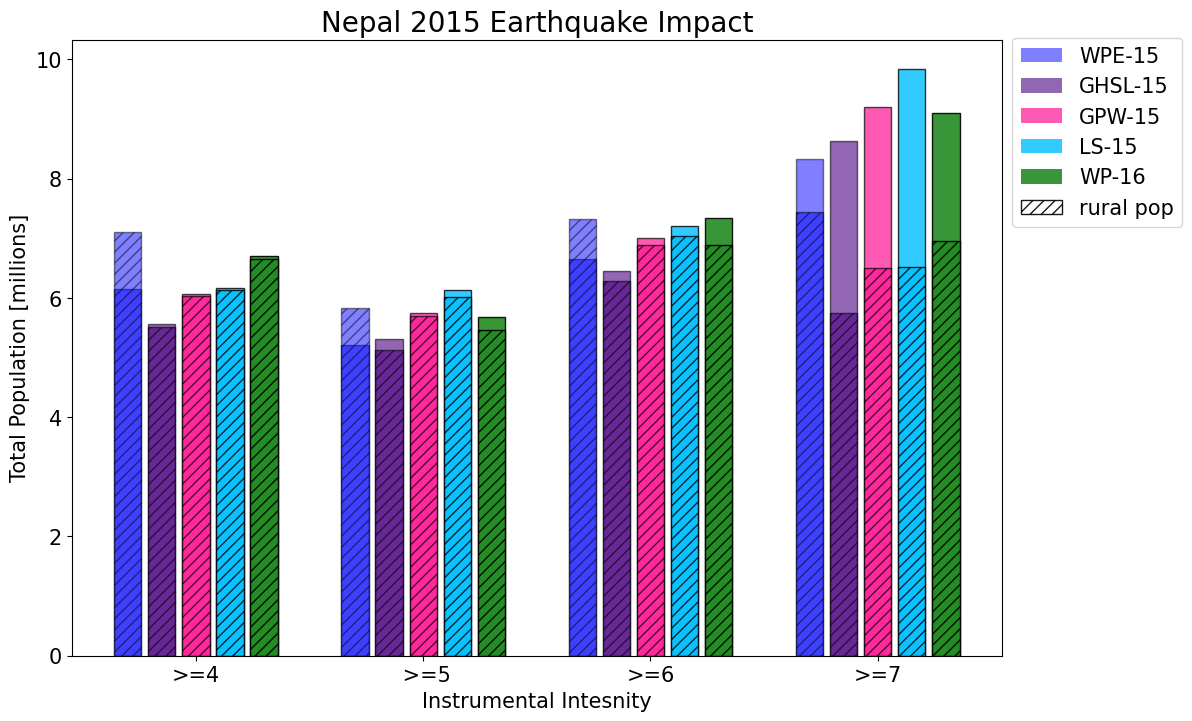

In [135]:
# Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (12, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**6

# All Quake
data = group(npl_all)

# Bar locations
a = [1-.3,2-.3,3-.3, 4-.3]
b = [1-.15,2-.15,3-.15,4-.15]
c = [1,2,3,4]
d = [1+.15,2+.15,3+.15,4+.15]
e = [1+.3,2+.3,3+.3,4+.3]

# plots
plt.bar(a, data.esri2015_n / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black')
plt.bar(b, data.ghs2015_np / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black')
plt.bar(c, data.gpw2015_np / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black')
plt.bar(d, data.ls2015_npl / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black')
plt.bar(e, data.wp2016_npl / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black')

# Fake plot for rural hatch legend 
plt.bar(e, data.wp2016_npl / scale, width=0.12, align='center', alpha  = 0, color = 'white', ec = 'black',hatch = "///")

# rural quake
data = group(npl_rural)
plt.bar(a, data.ESRI16_mat / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black', hatch = "///")
plt.bar(b, data.GHS15_matc / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black', hatch = "///")
plt.bar(c, data.GPWv4_matc / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black', hatch = "///")
plt.bar(d, data.LS15_match / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black', hatch = "///")
plt.bar(e, data.WP16_match / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black', hatch = "///")

# legend
legend_elements = [Patch(facecolor=ESRI16_c, alpha = 0.5, edgecolor=None, label='WPE-15'),
                  Patch(facecolor=GHS15_c, alpha = 0.6, edgecolor=None, label='GHSL-15'),
                  Patch(facecolor=GPWv4_c, alpha = 0.7, edgecolor=None, label='GPW-15'),
                  Patch(facecolor=LS15_c, alpha = 0.8, edgecolor=None, label='LS-15'),
                  Patch(facecolor= WP16_c, alpha = 0.9, edgecolor=None, label='WP-16'),
                  Patch(facecolor= 'white', alpha = 0.9,  hatch = '///', edgecolor='black', label='rural pop')]
plt.legend(handles = legend_elements, bbox_to_anchor=(1, 1.02), loc='upper left', ncol=1, fontsize = 15);

# Labels / Titles
axs.set_title('Nepal 2015 Earthquake Impact', size = 20)
axs.set_xlabel('Instrumental Intesnity', fontsize = 15)
axs.set_ylabel('Total Population [millions]', fontsize = 15)

# Ticks
ticks_bar = ['>=4', ' >=5', '>=6', '>=7'];
plt.xticks([1,2,3,4], ticks_bar, fontsize = 15);
plt.yticks(fontsize = 15);

In [ ]:
# save it out
fig_out = os.path.join(data_out + 'Figure.png')
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')